# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 6: Ensemble Methods, and Neural Networks


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

## Assumed Skills:
This assignment presumes knowledge of the following skills:
- Familiarity with sklearn's model objects
- Cross validation to estimate models' future performance
- Booststrapping to build alternative datasets
- Some instruction on Keras' interface for building and training neural networks

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

/Users/llawler/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Higgs Boson Discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. We shall explore the use of ensemble methods for this classification task.

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background). 

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: <a href = "https://www.nature.com/articles/ncomms5308">Baldi et al., Nature Communications 5, 2014</a>.

In [3]:
data_train = pd.read_csv('data/Higgs_train.csv')
data_test = pd.read_csv('data/Higgs_test.csv')

In [4]:
data_train.head()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0


In [5]:
X_train = data_train.iloc[:, data_train.columns != 'class']
y_train = data_train['class'].values
X_test = data_test.iloc[:, data_test.columns != 'class']
y_test = data_test['class'].values

## Question 1 (12pts): A Single Model
We start by fitting a basic model we can compare the other models to. We'll pick an optimally-tuned decision tree as the base model, because we'll later include random forests and want a fair comparison.

<div class='exercise'> Question 1</div>
** 1.1**  Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

** 1.2** Select an appropriate maximum depth-of-tree, and justify your choice.

**1.3** Report the model's classification accuracy on the test set.

**Answers**:  
**1.1:** Fit a decision tree model to the training set. Determine the depth-of-tree parameter via 5-fold cross-validation and plot the estimated performance +/- 2 standard deviations for the various depths.

In [6]:
data_train.describe()

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


In [7]:
data_train.dtypes

lepton pT                   float64
lepton eta                  float64
lepton phi                  float64
missing energy magnitude    float64
missing energy phi          float64
jet 1 pt                    float64
jet 1 eta                   float64
jet 1 phi                   float64
jet 1 b-tag                 float64
jet 2 pt                    float64
jet 2 eta                   float64
jet 2 phi                   float64
jet 2 b-tag                 float64
jet 3 pt                    float64
jet 3 eta                   float64
jet 3 phi                   float64
jet 3 b-tag                 float64
jet 4 pt                    float64
jet 4 eta                   float64
jet 4 phi                   float64
jet 4 b-tag                 float64
m_jj                        float64
m_jjj                       float64
m_lv                        float64
m_jlv                       float64
m_bb                        float64
m_wbb                       float64
m_wwbb                      

According to the paper, the feature data have already been standardized as follows: "Input features were standardized over the entire training/test set with mean 0 and s.d. 1, except for those features with values strictly >0 — these we scaled so that the mean value was 1." So I'll perform no further standardization/normalization and use the data as the paper used it.

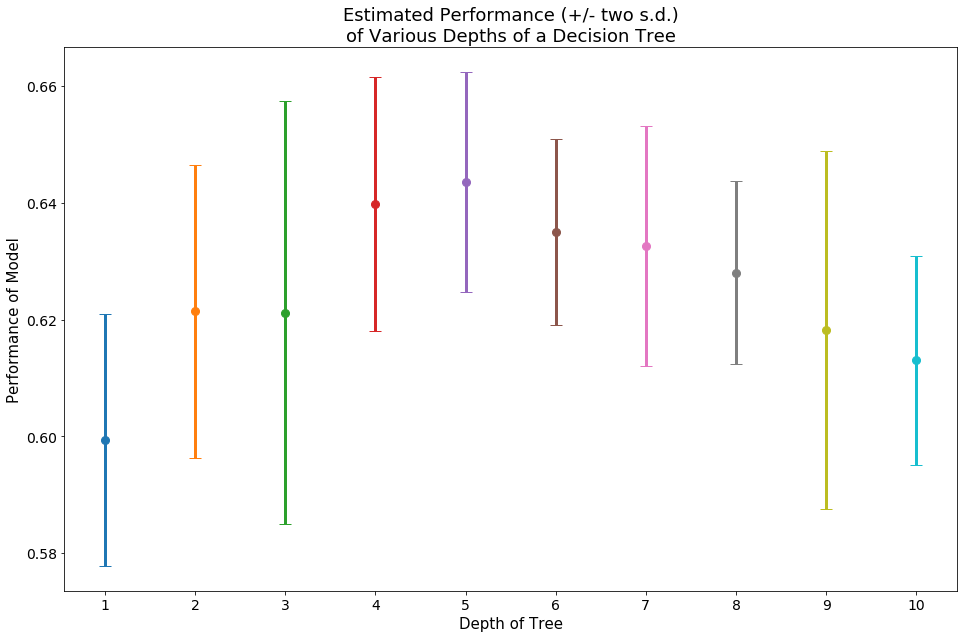

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (16, 10))

list_scores = []
for cur_depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth = cur_depth)
    scores = cross_val_score(model, X_train, y_train, cv = 5)
    score_dict = {
        'depth': cur_depth,
        'mean_score': np.mean(scores),
        'std_score': np.std(scores),
        'twostd_below': np.mean(scores) - np.std(scores)*2,
        'twostd_above': np.mean(scores) + np.std(scores)*2
    }
    list_scores.append(score_dict)
    ax.errorbar(x = cur_depth, y = np.mean(scores), yerr = np.std(scores)*2, fmt = 'o', lw = 3, 
                capsize = 6, markersize = 8)
    
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.tick_params(labelsize = 14)
ax.set_xlabel('Depth of Tree', fontsize = 15)
ax.set_ylabel('Performance of Model', fontsize = 15)
ax.set_title('Estimated Performance (+/- two s.d.)\nof Various Depths of a Decision Tree', fontsize = 18)
fig.subplots_adjust(hspace = .35, wspace = .25)

plt.show()

In [9]:
depth_scores_df = pd.DataFrame.from_dict(list_scores)
depth_scores_df[['depth', 'mean_score', 'std_score', 'twostd_below', 'twostd_above']]

,depth,mean_score,std_score,twostd_below,twostd_above
0,1,0.599405,0.010817,0.577772,0.621038
1,2,0.621407,0.012542,0.596323,0.646490
2,3,0.621213,0.018117,0.584980,0.657447
3,4,0.639809,0.010840,0.618128,0.661489
4,5,0.643605,0.009413,0.624778,0.662432
5,6,0.635005,0.008004,0.618998,0.651013
6,7,0.632606,0.010259,0.612088,0.653123
7,8,0.628005,0.007846,0.612313,0.643697
8,9,0.618201,0.015305,0.587591,0.648811
9,10,0.613006,0.008942,0.595122,0.630890


** 1.2** Select an appropriate maximum depth-of-tree, and justify your choice.

From the plot, it looks like a max depth of either 4 or 5 is most appropriate. On some versions of this plot, the upper limit of the error bar (ie mean + 2 s.d.) for a depth of 5 is higher than the upper limit for a depth of 4; in other versions, the error bar for a depth of 4 is higher than that of 5. However, the lower limit of the error bar (ie mean - 2 std dev) for depth of 5 is consistently higher than a depth of 4 (and all other depths). The mean score of depth 5 is also consistently higher than that of depth 4 (even if not by much) and all other depths. Because the lower limit of error and the mean score of depth 5 are both consistently higher than depth of 4, with the upper limit sometimes being higher than depth of 4, I will choose a depth of 5 as the maximum depth of the tree.

**1.3** Report the model's classification accuracy on the test set.

In [10]:
print('Model of depth 5, classification accuracy on test set: {}'.format(
    DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train).score(X_test, y_test)))

Model of depth 5, classification accuracy on test set: 0.648


## Question 2 (14 pts): Bagging
Bagging is the technique of building the same model on multiple bootstraps from the data and combining each model's prediction to get an overall classification. In this question we build an example by hand and study how the number of bootstrapped datasets impacts the combined accuracy.

<div class='exercise'> Question 2</div>
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. Record each tree's prediction. In particular, produce a dataset like those below, where each row is a training example, each column is a tree from the forest, and each entry is that tree's prediction for that training example.

`bagging_train`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|training row 1| binary value | binary value|... |binary value|
|training row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

`bagging_test`:

|     |bootstrap model 1's prediction|bootstrap model 2's prediction|...|bootstrap model 25's prediction|
| --- | --- | --- | --- |
|test row 1| binary value | binary value|... |binary value|
|test row 2| binary value| binary value|... |binary value|
|...| ...| ...|... |... |

Store these results as `bagging_train` and `bagging_test`.

**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

**Hints**
- Use `resample` from sklearn to easily bootstrap the x and y data.
- use `np.mean` to easily test for majority. If a majority of models vote 1, what does that imply about the mean?

In [11]:
def running_predictions(prediction_dataset, targets):
    """A function to predict examples' class via the majority among trees (ties are predicted as 0)
    
    Inputs:
      prediction_dataset - a (n_examples by n_sub_models) dataset, where each entry [i,j] is sub-model j's prediction
          for example i
      targets - the true class labels
    
    Returns:
      a vector where vec[i] is the model's accuracy when using just the first i+1 sub-models
    """
    
    n_trees = prediction_dataset.shape[1]
    
    # find the running percentage of models voting 1 as more models are considered
    running_percent_1s = np.cumsum(prediction_dataset, axis=1)/np.arange(1,n_trees+1)
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    return np.mean(running_correctnesss,axis=0)
    # returns a 1-d series of the accuracy of using the first n trees to predict the targets

**Answers**:  
**2.1** Create 25 bootstrapped replications of the original training data, and fit a decision tree of depth 5 to each. In particular, produce a dataset similar to 2.1, where each row is a training example, each column is a tree from the forest, but each entry is that tree's prediction of the _probability_ that training example comes from class 1.

In [12]:
# bootstrapping
bagging_train_array = np.zeros((len(X_train), 25))
bagging_test_array = np.zeros((len(X_test), 25))
N = 25
for i in range(N):
    x_train_boot, y_train_boot = resample(X_train, y_train)
    model = DecisionTreeClassifier(max_depth = 5).fit(x_train_boot, y_train_boot)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    bagging_train_array[:,i] = train_pred
    bagging_test_array[:,i] = test_pred

In [13]:
# create row and column names
col_names = [f'model_{i}_pred' for i in range(1, 26)]

In [14]:
bagging_train = pd.DataFrame(bagging_train_array, columns = col_names)
bagging_train.head()

,model_1_pred,model_2_pred,model_3_pred,model_4_pred,model_5_pred,model_6_pred,model_7_pred,model_8_pred,model_9_pred,model_10_pred,model_11_pred,model_12_pred,model_13_pred,model_14_pred,model_15_pred,model_16_pred,model_17_pred,model_18_pred,model_19_pred,model_20_pred,model_21_pred,model_22_pred,model_23_pred,model_24_pred,model_25_pred
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [15]:
bagging_test = pd.DataFrame(bagging_test_array, columns = col_names)
bagging_test.head()

,model_1_pred,model_2_pred,model_3_pred,model_4_pred,model_5_pred,model_6_pred,model_7_pred,model_8_pred,model_9_pred,model_10_pred,model_11_pred,model_12_pred,model_13_pred,model_14_pred,model_15_pred,model_16_pred,model_17_pred,model_18_pred,model_19_pred,model_20_pred,model_21_pred,model_22_pred,model_23_pred,model_24_pred,model_25_pred
0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


**2.2** _Aggregate_ all 25 _bootstrapped_ models to get a combined prediction for each training and test point: predict a 1 if and only if a majority of the 25 models predict that example to be from class 1. Verify that this bagging model scores either 67% or 68% accuracy on the test set.

Note: to actually get the combined prediction in integer form (1s and 0s), instead of python's boolean form (True and False), I did the below loops instead of doing only np.mean(dataframe, axis = 1).

In [16]:
meta_train_pred = np.zeros(len(X_train))
for i in range(len(X_train)):
    if np.mean(bagging_train.iloc[i]) > 0.5:
        meta_train_pred[i] = 1
    else:
        meta_train_pred[i] = 0
meta_train_pred

array([1., 0., 0., ..., 0., 1., 1.])

In [17]:
print("Train accuracy (classified by majority vote): {}%".format(
    np.mean(meta_train_pred == y_train)*100))

Train accuracy (classified by majority vote): 72.08%


In [18]:
meta_test_pred = np.zeros(len(X_test))
for i in range(len(X_test)):
    if np.mean(bagging_test.iloc[i]) > 0.5:
        meta_test_pred[i] = 1
    else:
        meta_test_pred[i] = 0
meta_test_pred

array([1., 1., 0., ..., 0., 0., 1.])

In [19]:
print("Test accuracy (classified by majority vote): {}%".format(
    np.mean(meta_test_pred == y_test)*100))

Test accuracy (classified by majority vote): 67.86%


The test accuracy is indeed 68%, as classified by majority vote.

**2.3** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions` function to get the model's accuracy score when using only 1,2,3,4,... of the bootstrapped models. Make a plot of training and test set accuracy as a function of number of bootstraps.

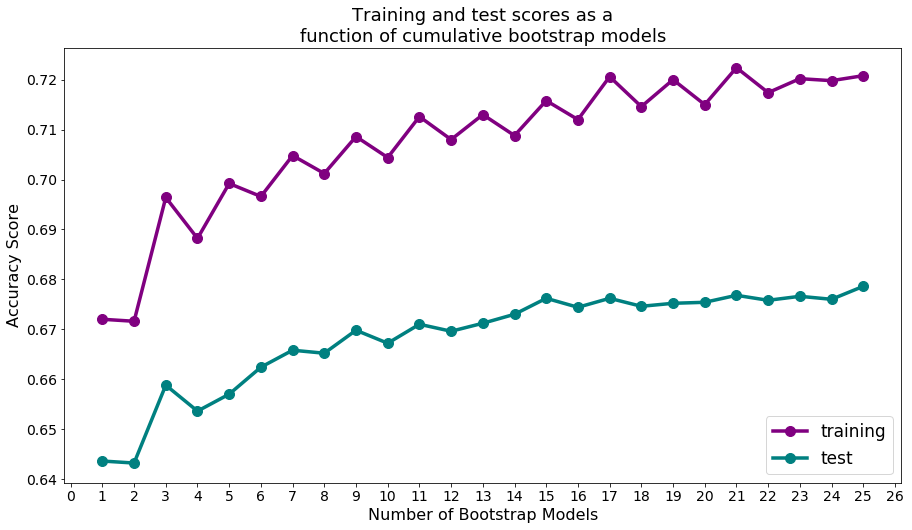

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))

models = list(range(1, 26))

ax.plot(models, running_predictions(bagging_train.values, y_train), 'o-', 
        markersize = 10, lw = 3.5, color = 'purple', label = 'training')
ax.plot(models, running_predictions(bagging_test.values, y_test), 'o-', 
        markersize = 10, lw = 3.5, color = 'teal', label = 'test')

ax.set_xlabel('Number of Bootstrap Models', fontsize = 16)
ax.set_ylabel('Accuracy Score', fontsize = 16)
ax.set_title('Training and test scores as a\nfunction of cumulative bootstrap models', fontsize = 18)
ax.tick_params(labelsize = 14)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.legend(loc = 'lower right', fontsize = 17)

plt.show()

**2.4** Analyze the graph from 2.3 and discuss the effect of adding more bootstrapped models to the ensemble. What number of trees would you use in a production model to be cost-effective?

Initially, the addition of bootstrap models dramatically affects the accuracy score of both the training and test sets. The greatest change in accuracy scores is seen within the first 7 models. After these 7 models, the addition of more models does improve the accuracy score, but not as dramatically. The improvement in accuracy score appears to plateau (with minor increases and decreases in score) after 11 trees have been included in the overall meta/cumulative model. The accuracy scores at 9 trees and at 11 trees for both the training and test set seem very close, respective to the number of trees (confirmed below). Since 11 trees is only very minimally better than 9 trees, I would use 9 trees in a production model in order to maximize both accuracy and also cost-effectiveness.

When re-running through this codebook, the graph showed 15 and 17 trees as having slightly improved performance over 9 and 11 trees. However that improvement is so minimal that is not worth considering either number of trees due to their negative effect on cost-effectiveness.

In [21]:
print('Training accuracy scores: 9 trees =',running_predictions(bagging_train.values, y_train)[8], 
      'and 11 trees =',running_predictions(bagging_train.values, y_train)[10])
print('Test accuracy scores: 9 trees =',running_predictions(bagging_test.values, y_test)[8], 
      'and 11 trees =',running_predictions(bagging_test.values, y_test)[10])

Training accuracy scores: 9 trees = 0.7086 and 11 trees = 0.7126
Test accuracy scores: 9 trees = 0.6698 and 11 trees = 0.671


In [22]:
print('Training accuracy scores: 15 trees =',running_predictions(bagging_train.values, y_train)[14], 
      'and 17 trees =',running_predictions(bagging_train.values, y_train)[16])
print('Test accuracy scores: 17 trees =',running_predictions(bagging_test.values, y_test)[14], 
      'and 11 trees =',running_predictions(bagging_test.values, y_test)[16])

Training accuracy scores: 15 trees = 0.7158 and 17 trees = 0.7206
Test accuracy scores: 17 trees = 0.6762 and 11 trees = 0.6762


## Question 3 (6 pts): Random Forests
Random Forests are closely related to the bagging model we built by hand in question 2. In this question we compare our by-hand results with the results of using `RandomForestClassifier` directly.

<div class='exercise'> Question 3</div>
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the bagging model from Question 2.

**3.2** There are two improvements Random Forests make to the pure bagging approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

**Hints**:
 - Random forests do not combine each tree's prediction via a majority vote. What do they use instead?

## **Answers**:  
**3.1** Fit a `RandomForestClassifier` to the original `X_train` data using 25 trees and a depth of 5. Comment on the model's test performance compared to the model from Question 2.

In [24]:
RandomForestClassifier(n_estimators = 25, max_depth = 5).fit(X_train, y_train).score(X_test, y_test)

0.6802

The Random Forest model's test performance is 68-69% (depending on the RandomState instance), which is ~1-2% higher than the test performance in the bagging model. The RandomForestClassifier does slightly better than bagging but not dramatically better. 

**3.2** There are two improvements Random Forests make to the pure bagging approach in Question 2. What are they, and how do they help the random forest model do better than the pure bagging model?

Random Forests improve upon bagging by using a randomly selected subset of the predictors at each split in the tree; from this subset, it then selects the optimal predictor and corresponding threshold for the split. This allows for de-correlation of the trees, thereby reducing the variance.<br>
The Random Forest implementation in sklearn does not, by default, use a majority vote when combining each tree's prediction. It averages the probabilistic predictions across all trees and then classifies according to that average probabalistic prediction. This allows for all trees in the forest to be incorporated into the 'vote' instead of the only the majority and could provide for a more accurate prediction.

## Question 4 (12 pts): Boosting
In this question we explore a counterpart to bagging, where each new model is trained on a dataset weighted towards observations that the current set of models predicts incorrectly. 

We'll focus on the AdaBoost flavor of boosting and examine what happens to the ensemble model's accuracy over the algorithm's run.

<div class='exercise'> Question 4</div>
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.  

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

**Answers**:  
**4.1** Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth 3 as the base learner and a learning rate 0.05, and run the boosting for 400 iterations. Use the `staged_score` method to help make a plot of the effect of the number of estimators/iterations on the model's train and test accuracy.

In [25]:
model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 400,
                          learning_rate = 0.05).fit(X_train, y_train)
train_staged_score = model.staged_score(X_train, y_train)
test_staged_score = model.staged_score(X_test, y_test)

In [26]:
train_scores = []
for score in train_staged_score:
    train_scores.append(score)

test_scores = []
for score in test_staged_score:
    test_scores.append(score)

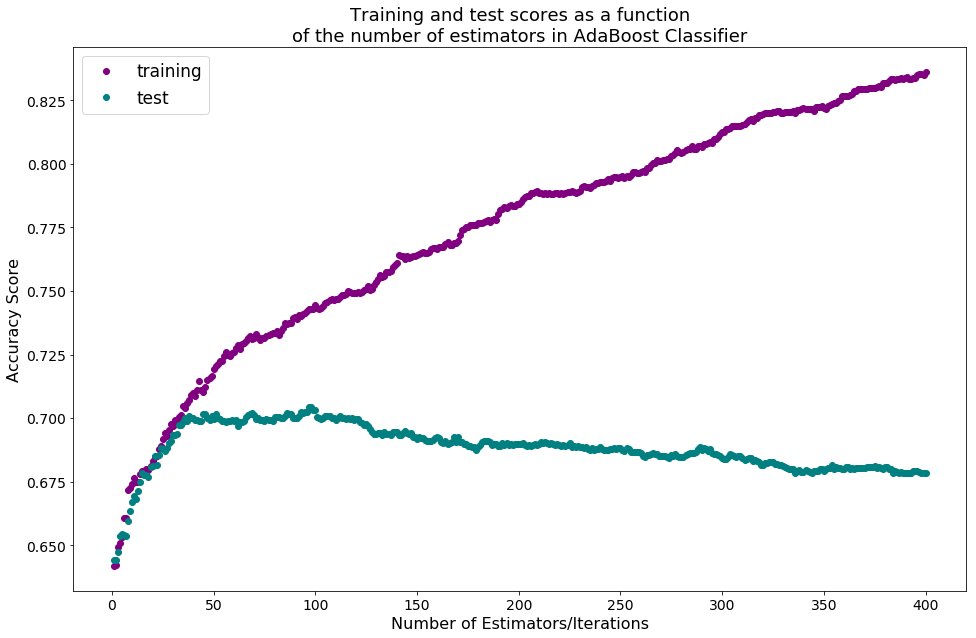

In [27]:
fig, ax = plt.subplots(1, 1, figsize = (16, 10))

stages = list(range(1, len(train_scores)+1))

ax.plot(stages, train_scores, 'o', color = 'purple', label = 'training')
ax.plot(stages, test_scores, 'o', color = 'teal', label = 'test')

ax.set_xlabel('Number of Estimators/Iterations', fontsize = 16)
ax.set_ylabel('Accuracy Score', fontsize = 16)
ax.set_title('Training and test scores as a function\nof the number of estimators in AdaBoost Classifier', 
             fontsize = 18)
ax.tick_params(labelsize = 14)
ax.legend(loc = 'best', fontsize = 17)

plt.show()

As the number of iterators increases, the training accuracy score increases and the test accuracy score decreases. The "sweet spot" of the test accuracy score appears to be between 30-40 estimators. After that point, the accuracy score slowy declines. It's possible that the model becomes overfit after this sweet spot, which is why the training accuracy continues to increase, and we see a decrease in the test score.

**4.2** Repeat the plot above for a base learner with depth in (1,2,3,4). What trends do you see in the training and test accuracy?

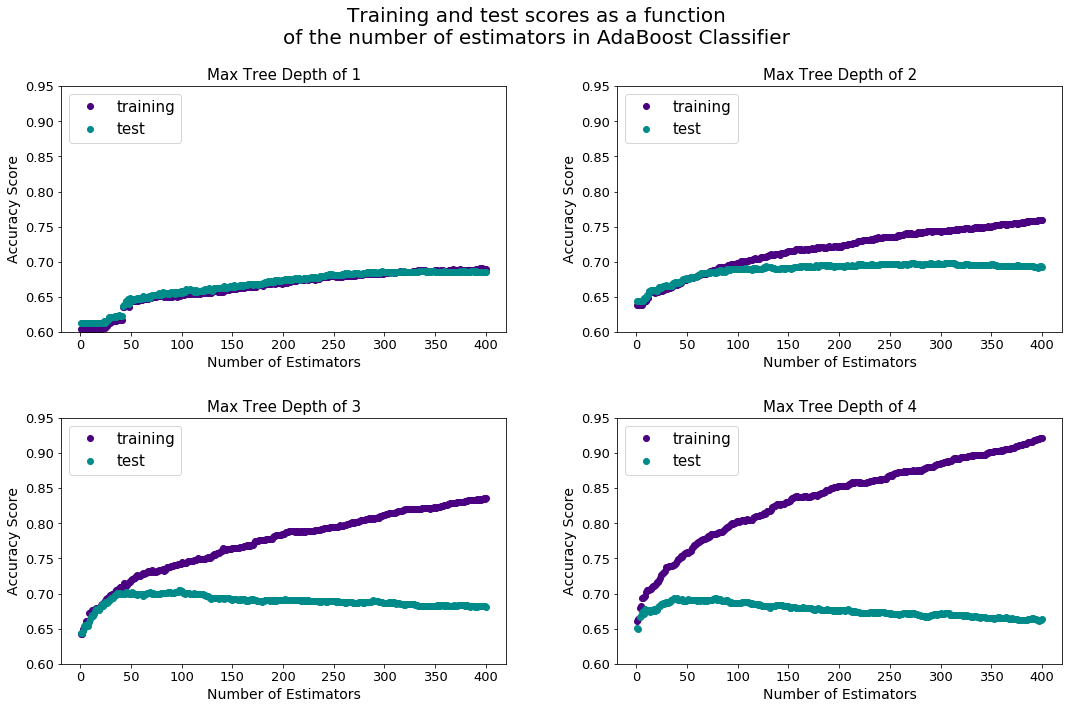

In [28]:
fig, axs = plt.subplots(2, 2, figsize = (15, 10))
axs = axs.ravel()

depths = [1, 2, 3, 4]

for i, cur_depth in enumerate(depths):
    model = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = cur_depth), 
                               n_estimators = 400, learning_rate = 0.05).fit(X_train, y_train)
    train_staged_score = model.staged_score(X_train, y_train)
    test_staged_score = model.staged_score(X_test, y_test)

    train_scores = []
    for score in train_staged_score:
        train_scores.append(score)

    test_scores = []
    for score in test_staged_score:
        test_scores.append(score)
     
    stages = list(range(1, len(train_scores)+1))
    
    axs[i].plot(stages, train_scores, 'o', color = 'indigo', label = 'training')
    axs[i].plot(stages, test_scores, 'o', color = 'darkcyan', label = 'test')
    axs[i].set_xlabel('Number of Estimators', fontsize = 14)
    axs[i].set_ylabel('Accuracy Score', fontsize = 14)
    axs[i].set_title('Max Tree Depth of {}'.format(cur_depth), fontsize = 15)
    axs[i].legend(loc = 'upper left', fontsize = 15)
    axs[i].tick_params(labelsize = 13)
    axs[i].set_ylim(0.60, 0.95)

fig.suptitle('Training and test scores as a function\nof the number of estimators in \
AdaBoost Classifier', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top = 0.87, hspace = .35, wspace = .25)

plt.show()

As the depth of the trees increases, the training and test scores start to diverge farther and farther away from each other. At a depth of one, their scores are almost identical and remaining pretty consistent and low. With a depth of two, we can see the training and test scores start to get larger, sooner, but the training scores are starting to increase more rapidly than the test scores. With a depth of 3, this pattern becomes even more apparent as the train score shoots away from the test score at ~40 estimators (where the test score achieves its maximum). With a depth of 4, the training diverge even farther apart from the test scores.

**4.3** Based on the plot from 4.2, what combination of base learner depth and number of iterations seems optimal? Why?


A depth of 3, with approximately 40 estimators seems optimal. At a depth of 3, the test score appears to reach a maximum value (~0.70, if not a littler higher). A depth of 3 reaches this peak value with fewer estimators than a depth of 1 or 2 (when comparing to the maximum test score of those lower depths), and about the same number of estimators as a depth of 4. The test score of a depth of 4 seems to be close to 0.70 as well, but looks slightly below it. Choosing a depth of 3 will be more cost-effective than a depth of 4, and picking ~ 40 estimators will maximize the test score and minimize any negative impacts to cost-effectiveness.

**4.4** AdaBoost doesn't combine its sub-models via simple majority vote, or by averaging probabilities. What does it use instead, and why do you think that combination rule was chosen?

AdaBoost combines its sub-models by using a weighted probability of all the sub-models predictions. It determines the weights by assessing the error at each iteration of the model. This combination rule was likely chosen to not penalize overconfident classifications and to downplay classifications of weaker models.
source: https://en.wikipedia.org/wiki/AdaBoost#Weighting

## Question 5 (18 pts): Ensembling
In this question we take the running theme of combining model to its extreme. So far, we have been combining the predictions of relatively bad models; in this section we'll combine several strong models and achieve our best accuracy yet.

We provide well-tuned models in the file `models.pkl`. The code below will read in this data for you. The model_dict object contains 5 tuned models, under the names "Ada", "KNN", "Logit", "QDA", and "RF".

**5.1**: Report each of the 5 tuned models' score on the test set, so that you can compare to these scores later.

**5.2**: Read in the fresh dataset `data/Higgs_tune.csv` Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

**5.6**: Suggest one way to improve on the model above

In [29]:
# will produce a warning under most versions of SKlearn, but it should be OK to ignore
# if you get weird errors or the models all stink, let us know

import pickle
with open("data/models.pkl", 'rb') as infile:
    model_dict = pickle.load(infile)

**Answers**:

**5.1**: Report each model's score on the test set, so that you can compare to these scores later.

In [30]:
model_keys = model_dict.keys()
list_scores = np.zeros(len(model_keys))
list_keys = []

for i, key in enumerate(model_keys):
    list_scores[i] = model_dict[key].score(X_test, y_test)
    list_keys.append(key)

In [31]:
model_test_scores = pd.DataFrame({
    'model': list_keys,
    'test_score': list_scores
})
print('Table of five models and their respective scores on the test set:')
model_test_scores

Table of five models and their respective scores on the test set:


,model,test_score
0,Ada,0.6756
1,RF,0.6748
2,Logit,0.6384
3,QDA,0.6330
4,KNN,0.5774


**5.2**: Read in the fresh dataset `data/Higgs_tune.csv`.  Similar to 2.1, build `ensemble_tune` and `ensemble_test`, datasets containing each tuned model's prediction of P(this point belongs to class 1) for each of the tuning and test points.

In [32]:
data_tune = pd.read_csv('data/Higgs_tune.csv')
X_tune = data_tune.iloc[:, data_tune.columns != 'class']
y_tune = data_tune['class'].values

In [33]:
ensemble_tune_array = np.zeros((len(X_tune), 5))
ensemble_test_array = np.zeros((len(X_test), 5))

for i, key in enumerate(model_keys):
    model = model_dict[key]
    ensemble_tune_array[:,i] = model.predict(X_tune)
    ensemble_test_array[:,i] = model.predict(X_test)

In [34]:
ensemble_tune = pd.DataFrame(ensemble_tune_array, columns = list_keys)
ensemble_tune.head()

,Ada,RF,Logit,QDA,KNN
0,0.0,0.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0


In [35]:
ensemble_test = pd.DataFrame(ensemble_test_array, columns = list_keys)
ensemble_test.head()

,Ada,RF,Logit,QDA,KNN
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,0.0
2,0.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,1.0


**5.3**: Build a meta-model trained on `ensemble_tune` and predicting the tuning set labels (e.g., a LogisticRegression or RandomForest). Which model does your meta-model consider most important, and how well does your meta-model perform on the test set?

In [36]:
meta_logreg = LogisticRegressionCV().fit(ensemble_tune, y_tune)
meta_logreg.coef_[0]

array([0.50150426, 0.72864542, 0.4366883 , 0.41026837, 0.13740615])

In [37]:
print('Meta model by logistic regression, test accuracy:',meta_logreg.score(ensemble_test, y_test))

Meta model by logistic regression, test accuracy: 0.6798


Based on the coefficients of the meta model (created with logistic regression), RandomForest (the second model) is most important, followed by boosting (first model). According to the coefficients, the least important model is the k-NN classifier.<br><br>
The test accuracy is 67.98% with the meta model. This is similar to the test accuracies found with the models in the previous sections (bagging, RF, and boosting). This meta model didn't improve upon the previous models.

**5.4**: Augment the `ensemble_tune` and `ensemble_test` datasets with the columns from the original tuning and test data to form `augmented_tune` and `augmented_test`. Fit a decision tree model to this new tuning data (max depth 5, no mximum number of features).

In [38]:
augmented_tune = pd.concat([ensemble_tune, X_tune], axis = 1)
augmented_tune.head()

,Ada,RF,Logit,QDA,KNN,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,0.0,0.0,1.0,1.0,1.0,0.717,-0.450,-0.0435,0.975,1.430,0.845,0.264,1.500,0.00,0.679,0.342,-1.570,0.00,0.977,0.704,-0.0185,2.55,0.713,-1.1200,0.494,0.0,1.230,1.050,1.12,0.710,0.540,0.673,0.655
1,1.0,1.0,1.0,1.0,0.0,0.719,1.390,0.1020,1.140,1.240,0.758,2.740,-1.030,0.00,0.660,0.804,1.070,2.21,0.418,1.570,-0.2030,0.00,0.771,-0.7270,-0.456,3.1,0.879,1.230,1.07,1.080,0.882,1.210,1.010
2,0.0,0.0,0.0,0.0,1.0,2.320,0.074,-0.6260,0.909,-0.795,1.240,-0.418,1.200,0.00,0.463,-0.355,0.151,2.21,0.683,0.717,0.6810,2.55,0.431,0.0978,-1.690,0.0,0.640,0.768,1.01,0.945,0.456,0.695,0.905
3,0.0,0.0,1.0,1.0,1.0,0.626,-0.346,-1.5800,2.100,0.878,1.140,-0.341,-1.150,0.00,0.415,-0.549,-0.313,2.21,1.620,-0.330,0.2520,2.55,0.517,1.5800,-1.690,0.0,1.700,1.100,1.27,0.973,0.433,0.971,0.977
4,0.0,0.0,0.0,0.0,0.0,0.320,-1.100,-0.8350,2.770,1.210,1.280,0.453,-0.698,2.17,1.140,0.221,0.602,2.21,1.290,1.060,-1.0500,0.00,0.734,1.6100,0.331,0.0,1.100,1.120,1.26,1.330,1.650,1.570,1.550


In [39]:
augmented_test = pd.concat([ensemble_test, X_test], axis = 1)
augmented_test.head()

,Ada,RF,Logit,QDA,KNN,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,1.0,1.0,1.0,1.0,0.884,-0.462,0.196,1.330,1.520,1.040,-1.5200,-1.46,2.17,0.361,-2.030,-0.253,0.00,0.337,-0.597,-0.324,2.55,0.493,1.030,-1.1400,0.0,1.450,0.791,1.400,1.250,0.713,0.812,0.821
1,1.0,1.0,1.0,1.0,0.0,0.780,-0.292,0.897,0.384,0.413,1.220,-0.4660,-0.92,0.00,1.100,-1.200,1.080,2.21,0.498,1.490,1.060,0.00,0.493,-0.344,-0.0918,0.0,0.812,0.728,0.975,0.637,0.569,0.777,0.715
2,0.0,0.0,1.0,1.0,1.0,0.353,-1.070,-1.740,1.170,-0.199,0.558,0.0574,-1.49,1.09,0.912,-1.080,0.571,0.00,0.781,-0.320,-1.040,2.55,0.616,-1.510,1.5500,0.0,0.829,1.060,0.992,0.825,0.365,0.800,0.766
3,1.0,1.0,1.0,1.0,1.0,0.757,0.822,-1.290,0.208,-0.151,1.220,-1.6400,1.53,0.00,1.680,0.189,-0.645,0.00,1.780,0.285,0.520,2.55,1.130,-0.932,0.1170,3.1,4.290,2.420,0.995,0.923,0.927,1.760,1.360
4,0.0,0.0,0.0,0.0,1.0,2.040,2.030,-0.472,0.424,-1.500,1.060,0.7980,1.22,2.17,0.805,-0.661,-1.460,0.00,0.885,1.440,0.809,0.00,1.290,0.493,-0.0791,3.1,0.895,0.936,1.030,1.560,1.150,1.120,1.160


In [40]:
print('DecisionTree fit on ensemble tune, test accuracy:',
      DecisionTreeClassifier(max_depth = 5).fit(ensemble_tune, y_tune).score(ensemble_test, y_test))
print('RandomForest fit on ensemble tune, test accuracy:',
      RandomForestClassifier(n_estimators = 30, max_depth = 5, random_state = 15).fit(
          ensemble_tune, y_tune).score(ensemble_test, y_test))
print('DecisionTree fit on augmented tune, test accuracy:',
      DecisionTreeClassifier(max_depth = 5).fit(augmented_tune, y_tune).score(augmented_test, y_test))
print('RandomForest fit on augmented tune, test accuracy:',
      RandomForestClassifier(n_estimators = 30, max_depth = 5, random_state = 15).fit(
          augmented_tune, y_tune).score(augmented_test, y_test))

DecisionTree fit on ensemble tune, test accuracy: 0.6806
RandomForest fit on ensemble tune, test accuracy: 0.681
DecisionTree fit on augmented tune, test accuracy: 0.68
RandomForest fit on augmented tune, test accuracy: 0.7066


I decided to build both a regular DecisionTree model and an ensembled Decision Tree model (aka Random Forest). I did this because I didn't see any improvement (only ~0.002 better) with the DecisionTree model on the augmented set when compared to the LogisticRegression meta-model on the ensemble set. In order to more accurately compare the DecisionTree and RF models on the augmented set with the ensemble set, I fit four models: DecisionTree on ensemble and augmented and RF on ensemble and augmented.

**5.5**: How well does the meta-tree do on the test set? Why does training a decision tree on the combination of original data and model predictions perform so well?

The decision tree model with a sole tree (ie DecisionTree) on both the ensemble and augmented sets got the same test accuracy score; there was no improvement by using the augmented set. The decision tree model built with multiple trees (n=30) and random subsets of predictors (ie RandomForest) had the same test accuracy as the sole tree model with the ensemble set. Improvement of ~3% was seen with the RF on the augmented model. The augmented version performs better because it includes already fitted models, along with the original features. Weighing fitted models and all of the original features allows for the model to further tune the fit that it may have 'missed' when initially building the 5 models.

**5.6**: Suggest one way to improve on the model above

If a single Decision Tree had performed much better (as question 5.5 implies), I would have said to perform a RandomForest as an improvement. Since the RandomFores is what performed betterin 5.5, here are my other suggestions:<br>A correlation matrix could be built to determine which of the predictors in the original tune set are predicted. Those that are highly correlated could be represented by one instead of all features in the model. This might provide a better fit to the model.<br>
Polynomial terms (on the original tune features, not the models) could be added to the current RandomForest.<br>
More trees could be added to the RandomForest to improve the fit.

----
Your answer here

----

## Question 6 (12 pts): Understanding
This question is an overall test of your knowledge of this homework's material. You may need to refer to lecture notes and other material outside this homework to answer these questions.

<div class='exercise'> Question 6</div>
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

**6.4** Suppose you have 10,000 training observations and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging in general) tie to overfitting versus underfitting?

**Answers**:  
**6.1** How do ensembling, boosting, and bagging all relate: what is common to all three, and what is unique to each of them?

Ensembling, boosting, and bagging all train and aggregate multiple models into one overall model, to make better predictions than a sole model could on its own. Bagging and boosting are often applied to decision trees; these two ensemble methods only incorporate one type of model in each ensemble. On the other hand, ensembling is more general and can aggregate different models in one ensemble model (ie aggregate LogisticRegression, RandomForest, and k-NN classifier together). By training and incorporating multiple models, these three techniques/models are able to reduce the variance of the final model.<br>Ensembling, as mentioned previously, is the umbrella term for models like boosting, bagging, and Random Forest; it is a general term for using multiple algorithms/models to create better predictive model.<br>Bagging takes an ensemble of decision trees that were trained on bootstrap samples of the training data and averages the predictions.<br>Boosting iteratively builds a model by fitting for the residuals of the current ensemble model; it starts by fitting a decision tree to the overall data. Then a decision tree is fit to the residuals of that model and the new decision tree is added to the original tree and becomes the new ensemble method; every subsequent tree is fit to the residuals of the most current ensemble and is then the ensemble is updated with the the addition of that new tree.

**6.2** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time?

Bagging is better suited to parallelization. Boosting is an iterative process that builds off of its preceding ensemble models, by fitting to the residuals; boosting is therefore not suited to parallelization. Since bagging takes an ensemble of decision trees that were trained on bootstrap samples, multiple computers could be training decision trees on bootstrap samples of the same training data (since bootstrapping samples with replacement, this is okay) and then all of the trees could be aggregated once they've all been trained.

**6.3** What is the impact of having too many trees/iterations in boosting and in bagging? In which instance is it worse to overshoot?

Having too many trees/iterations in bagging only improves the model; eventually, the effect of including more trees levels out, and the downside to adding too many trees is the additional time it takes to continue fitting more trees.<Br>Having too many trees/iterations in boosting can potentially overfit the model (so it is worse to overshoot with this model). With too many trees, the model will eventually have fit all of the residuals of ensemble model and it will be overfit. To prevent this, cross-validation is used to select the optimal number of trees.

**6.4** Suppose you have 10,000 training examples and have selected (non-polynomial) linear regression as your base model. Which technique will help your model more, boosting or bagging? How does your choice (and boosting/bagging general) tie to overfitting versus underfitting?


Bagging will help the model more. By performing linear regression on bootstrapped samples of the 10,000 training examples, the aggregate linear regression model becomes stronger. With multiple regression lines, we are able to approximate the true variance of all of the betas, along with compute their significance. Bagging can help linear regression if there is an underfitting problem; it can provide a better fit to the training data by getting closer to the true coefficients. We're able to identify a 95% CI of our predictions, as each prediction will have a normal distribution determined through bootstrapping.<br>
Boosting doesn't add much value to linear regression. Both boosting and linear regression are approach regression as an optimization problem and are attempting to minimize the mean squared error (boosting does this through gradient descent). Since they operate in similar manners, boosting wouldn't improve linear regression much. It could actually potentially overfit the linear regression model if it continually fits the residuals.<br>

source: https://stats.stackexchange.com/questions/186966/gradient-boosting-for-linear-regression-why-does-it-not-work

<hr style='height:2pt'>
## Question 7 (26 points): Neural Networks
Neural networks are, of course, a large and complex topic that cannot be covered in a single homework. Here we'll focus on the key idea of NNs: they are able to learn a mapping from example input data (of fixed size) to example output data (of fixed size). We'll also partially explore what patterns the neural network learns and how well they generalize.

In this question we'll see if Neural Networks can learn a (limited) version of the Fourier Transform. (The Fourier Transform takes in values from some function and returns a set of sine and cosine functions which, when added together, approximate the original function.)

In our specific problem, we'll try to teach a network to map from  a function's 1000 sample y-values to the four features of the sine and cosine waves that make up that function. Thus, the network is attempting to learn a mapping from a 1000-entry vector down to a 4-entry vector. Our X_train dataset is thus N by 1000 and our y_train is N by 4. 

We'll use 6 data files in this question:
- `sinewaves_X_train.npy` and `sinewaves_y_train.npy`: a (10,000 by 1,000) and (10,000 by 4) training dataset. Examples were generated by randomly selecting a,b,c,d in the interval [0,1] and building the curve $a\sin(b\,x) + c\cos(d\,x)$
- `sinewaves_X_test.npy` and `sinewaves_y_test.npy`: a (2,000 by 1,000) and (2,000 by 4) test dataset, generated in the same way as the training data
- `sinewaves_X_extended_test` and `sinewaves_y_extended_test`: a (9 by 1,000) and (9 by 4) test dataset, testing whether the network can generalize beyond the training data (e.g. to negative values of $a$)

**These datasets are read in to their respective variables for you.**

<div class='exercise'> Question 7</div>
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced samples in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$. This pattern (y_train is the true parameters of the curve in X_train) will always hold.

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of 0.2. You can train for longer if you wish- the fit tends to improve over time.

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X_test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefficients that generated the data?

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

**7.8** Is there something that stands out about the difficult examples, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

**Hint**:
- Keras's documentation and examples of a Sequential model are a good place to start.
- A strong model can achieve validation error of around 0.03 on this data and 0.02 is very good.

In [41]:
def plot_predictions(model, test_x, test_y, count=None):
    # Model - a Keras or SKlearn model that takes in (n,1000) training data and predicts (n,4) output data
    # test_x - a (n,1000) input dataset
    # test_y - a (n,4) output dataset
    # This function will plot the sine curves in the training data and those implied by the model's predictions.
    # It will also print the predicted and actual output values.
    
    #helper function that takes the n by 4 output and reverse-engineers 
    #the sine curves that output would create
    def y2x(y_data):
        #extract parameters
        a=y_data[:,0].reshape(-1,1)
        b=y_data[:,1].reshape(-1,1)
        c=y_data[:,2].reshape(-1,1)
        d=y_data[:,3].reshape(-1,1)

        #build the matching training data
        x_points = np.linspace(0,10*np.pi,1000)
        x_data = a*np.sin(np.outer(b,x_points)) + c*np.cos(np.outer(d,x_points))
        return x_data
    
    #if <20 examples, plot all. If more, just plot 5
    if count==None:
        if test_x.shape[0]>20:
            count=5
        else:
            count=test_x.shape[0]
    
    #build predictions
    predicted = model.predict(test_x)
    implied_x = y2x(predicted)
    for i in range(count):
        plt.plot(test_x[i,:],label='true')
        plt.plot(implied_x[i,:],label='predicted')
        plt.legend()
        plt.ylim(-2.1,2.1)
        plt.xlabel("x value")
        plt.xlabel("y value")
        plt.title("Curves using the Neural Network's Approximate Fourier Transform")
        plt.show()
        print("true:", test_y[i,:])
        print("predicted:", predicted[i,:])
    
    

In [42]:
X_train = np.load('data/sinewaves_X_train.npy')
y_train = np.load('data/sinewaves_y_train.npy')

X_test = np.load('data/sinewaves_X_test.npy')
y_test = np.load('data/sinewaves_y_test.npy')

X_extended_test = np.load('data/sinewaves_X_extended_test.npy')
y_extended_test = np.load('data/sinewaves_y_extended_test.npy')

**Answers**:  
**7.1** Plot the first row of the `X_train` training data and visually verify that it is a sinusoidal curve

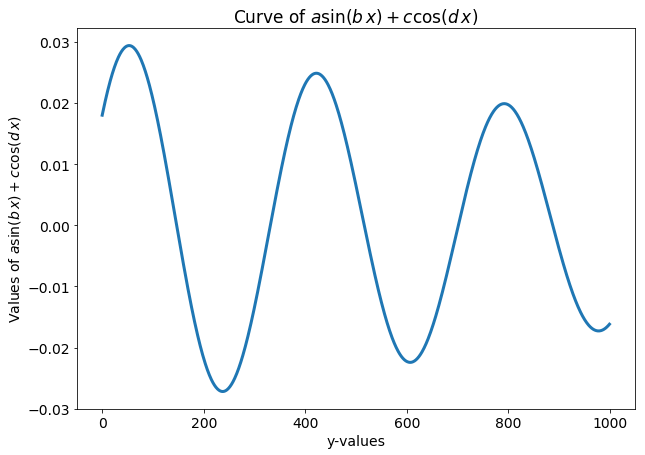

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (10, 7))

ax.plot(X_train[0], lw = 3)
ax.set_xlabel('y-values', fontsize = 14)
ax.set_ylabel('Values of $a\sin(b\,x) + c\cos(d\,x)$', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.set_title('Curve of $a\sin(b\,x) + c\cos(d\,x)$', fontsize = 17)

plt.show()

This is does look like a sinusoidal curve. Since each subsequent local minimum and local minimum is smaller in magnitude than its predecessor, this is likely a damped sinusoidal curve. 

**7.2** The first row of the `y_train` data is $[0.024, 0.533, 0.018, 0.558]$. Visually or numerically verify that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$ from the function $f(x) = 0.24\sin(0.533\,x) + 0.018\cos(0.558\,x)$...

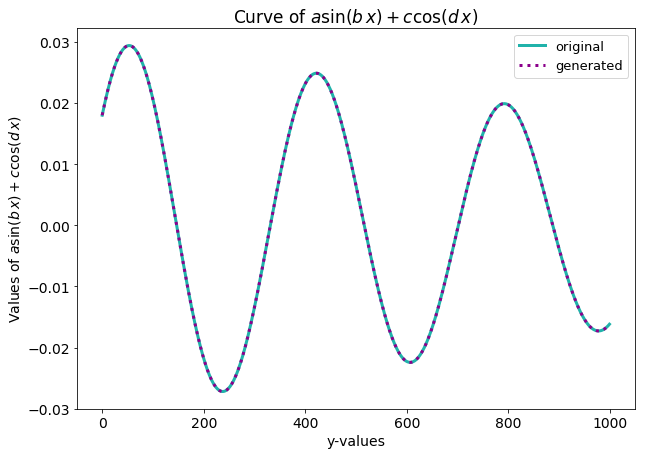

In [44]:
def curve_abcd(x):
    '''
    Take x value in radians and return function value
    '''
    return (0.024 * np.sin(0.533*x) + 0.018 * np.cos(0.558*x))

rads_10pi = np.linspace(0, 10*np.pi, 1000)

x_train_verify = []
for rads in rads_10pi:
    x_train_verify.append(curve_abcd(rads))
    
fig, ax = plt.subplots(1, 1, figsize = (10, 7))

ax.plot(X_train[0], lw = 3, color = 'lightseagreen', label = 'original')
ax.plot(x_train_verify, linestyle = ':', lw = 3, color = 'darkmagenta', label = 'generated')
ax.set_xlabel('y-values', fontsize = 14)
ax.set_ylabel('Values of $a\sin(b\,x) + c\cos(d\,x)$', fontsize = 14)
ax.tick_params(labelsize = 14)
ax.set_title('Curve of $a\sin(b\,x) + c\cos(d\,x)$', fontsize = 17)
ax.legend(loc = 'best', fontsize = 13)

plt.show()

The generated curve (plotted above, on top of the first row of the original X_train) used was created with 1000 evenly spaced points in $[0,10\pi]$. As we can see, it lies perfectly on top of the original curve. Therefore, we can conclude that the first row of X_train is 1000 equally-spaced points in $[0,10\pi]$.

**7.3** Use `Sequential` and `Dense` from Keras to build a fully-connected neural network. You can choose any number of layers and any number of nodes in each layer. 

In [45]:
X_train.shape

(10000, 1000)

In [46]:
y_train

array([[0.024     , 0.533     , 0.018     , 0.558     ],
       [0.25768382, 0.06592192, 0.43312975, 0.03556491],
       [0.26245374, 0.41740202, 0.69736748, 0.96583824],
       ...,
       [0.225431  , 0.37847827, 0.66219144, 0.75772051],
       [0.81292974, 0.03731505, 0.55551253, 0.02414299],
       [0.69628741, 0.30348788, 0.22004113, 0.09083877]])

In [47]:
model = Sequential([
    Dense(150, input_shape = (1000,), activation='relu'),
    Dense(75, activation = 'relu'),
    Dense(35, activation = 'relu'),
    Dense(15, activation = 'relu'),
    Dense(4, activation = 'linear')
])

**7.4** Compile your model via the line `model.compile(loss='mean_absolute_error', optimizer='adam')` and display the `.summary()`. Explain why the first layer in your network has the indicated number of parameters.

In [48]:
model.compile(loss = 'mean_absolute_error', optimizer = 'adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 150)               150150    
_________________________________________________________________
dense_2 (Dense)              (None, 75)                11325     
_________________________________________________________________
dense_3 (Dense)              (None, 35)                2660      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                540       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 64        
Total params: 164,739
Trainable params: 164,739
Non-trainable params: 0
_________________________________________________________________


The first layer in my network has 150150 parameters. This arises from the fact that we have 1000 inputs and 150 neurons, along with an added bias value, which allows the activation function to shift left or right. The parameters then consist of 150 weights for each input (each input goes through each neuron and has an associated weight with that connection; 150 * 1000 = 150,000 parameters from the inputs and neurons themselves). Additionally, there are 150 weights associated with the bias value, giving us another 150 parameters, for a total of 150150 parameters. 

courtesy of: https://stackoverflow.com/questions/2480650/role-of-bias-in-neural-networks

**7.5** Fit your model to the data for 50 epochs using a batch size of 32 and a validation split of .2. You can train for longer if you wish- the fit tends to improve over time.

In [49]:
model.fit(X_train, y_train, epochs = 50, batch_size = 32, validation_split = 0.2)

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 2s 189us/step - loss: 0.1493 - val_loss: 0.1015
Epoch 2/50
8000/8000 [==============================] - 1s 132us/step - loss: 0.0927 - val_loss: 0.0817
Epoch 3/50
8000/8000 [==============================] - 1s 136us/step - loss: 0.0786 - val_loss: 0.0746
Epoch 4/50
8000/8000 [==============================] - 1s 133us/step - loss: 0.0684 - val_loss: 0.0653
Epoch 5/50
8000/8000 [==============================] - 1s 133us/step - loss: 0.0605 - val_loss: 0.0560
Epoch 6/50
8000/8000 [==============================] - 1s 131us/step - loss: 0.0558 - val_loss: 0.0529
Epoch 7/50
8000/8000 [==============================] - 1s 133us/step - loss: 0.0526 - val_loss: 0.0489
Epoch 8/50
8000/8000 [==============================] - 1s 136us/step - loss: 0.0481 - val_loss: 0.0478
Epoch 9/50
8000/8000 [==============================] - 1s 148us/step - loss: 0.0459 - val_loss: 0.0446
Epoch 10/50
8000

**7.6** Use the `plot_predictions` function to plot the model's predictions on `X-test` to the true values in `y_test` (by default, it will only plot the first few rows). Report the model's overall loss on the test set. Comment on how well the model performs on this unseen data. Do you think it has accurately learned how to map from sample data to the coefecients that generated the data?

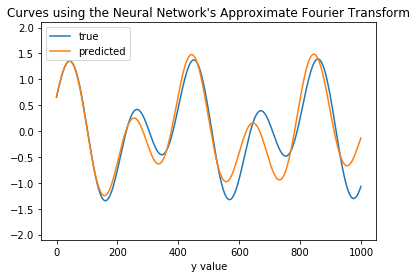

true: [0.86199664 0.98175913 0.65523998 0.4870337 ]
predicted: [0.82684416 1.0077194  0.67048144 0.46644315]


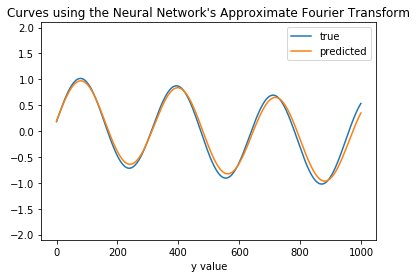

true: [0.8406355  0.63159555 0.18328701 0.11174618]
predicted: [0.7814837  0.62451035 0.19558804 0.10209295]


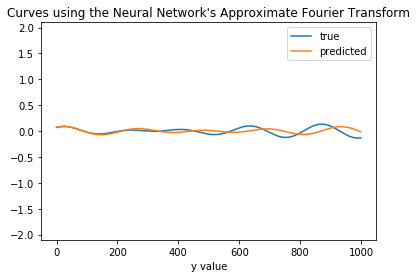

true: [0.06591224 0.75183886 0.06986143 0.91352303]
predicted: [0.05818664 0.732955   0.0744025  0.8339473 ]


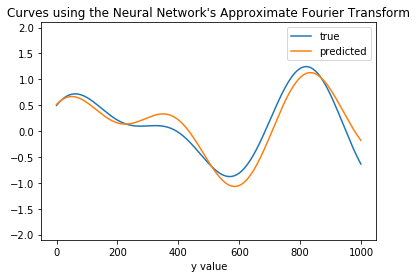

true: [0.75610725 0.30861152 0.49522059 0.48394499]
predicted: [0.68831927 0.28491655 0.5142851  0.49090642]


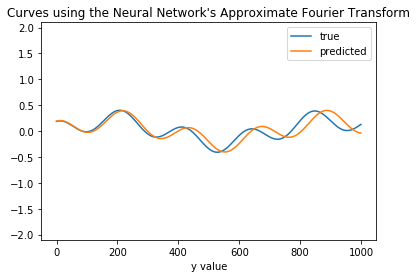

true: [0.2229353  0.27885697 0.18696198 0.94846283]
predicted: [0.21132235 0.2743931  0.19249731 0.90283054]


In [50]:
plot_predictions(model, X_test, y_test)

In [51]:
print('Model overall loss on test set:', model.evaluate(X_test, y_test))

2000/2000 [==============================] - 0s 42us/step
Model overall loss on test set: 0.027657634407281875


The overall loss on the test set is 0.026. This is a very low loss and is indicative of a strong model.<br><br>
The predicted values on some of the plots lie almost entirely on the true values (last plot and third plot), while predicted curves in other plots seem to be a slightly off from the true curve (first, second, and fourth plots). I think the model does seem to have accurately learned to map from sample data to the coefficients that generated the data; on average, it does appear that the predictions are correct, indicating there is low bias with this neural network.

**7.7** Examine the model's performance on the 9 train/test pairs in the `extended_test` variables. Which examples does the model do well on, and which examples does it struggle with?

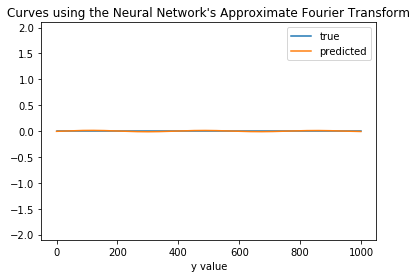

true: [0. 0. 0. 0.]
predicted: [ 0.01273191  0.5415659  -0.00494063  0.5182136 ]


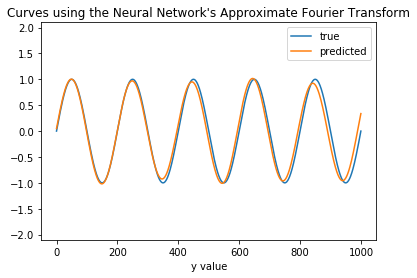

true: [1. 1. 0. 0.]
predicted: [0.97309345 1.0096016  0.04913387 0.59579945]


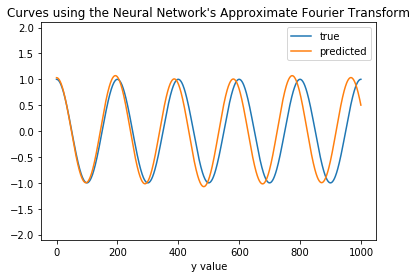

true: [0. 0. 1. 1.]
predicted: [0.04169359 0.3082965  1.0310661  1.0334537 ]


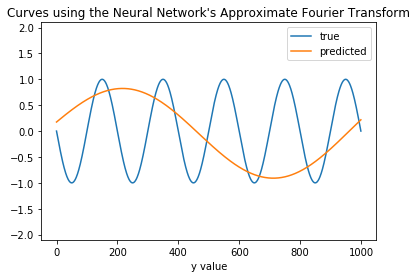

true: [-1.  1.  0.  0.]
predicted: [0.7484665  0.20769769 0.17483851 0.15708202]


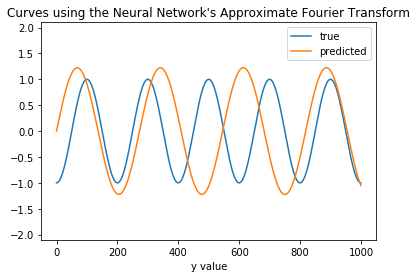

true: [ 0.  0. -1.  1.]
predicted: [ 1.2236968   0.73289466 -0.00124985  0.5581073 ]


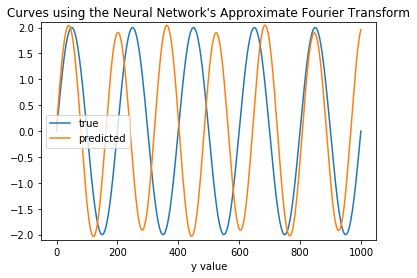

true: [2. 1. 0. 0.]
predicted: [1.9716709  1.2400253  0.09254912 0.6132034 ]


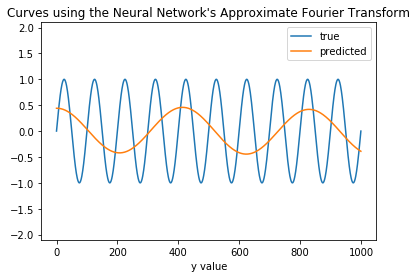

true: [1. 2. 0. 0.]
predicted: [0.02204408 0.17045671 0.4407546  0.48201585]


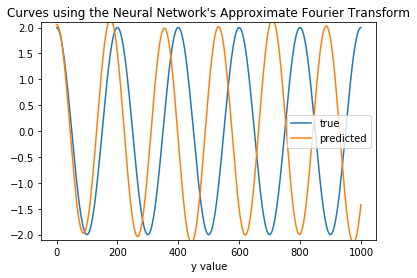

true: [0. 0. 2. 1.]
predicted: [0.10289665 0.34950593 2.0590258  1.1278738 ]


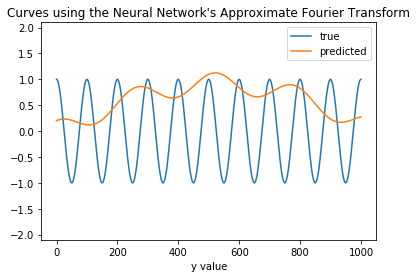

true: [0. 0. 1. 2.]
predicted: [0.92411715 0.09416493 0.20042604 0.76764435]


In [52]:
plot_predictions(model, X_extended_test, y_extended_test)

In [53]:
model.evaluate(X_extended_test, y_extended_test)

9/9 [==============================] - 0s 229us/step


0.4677004814147949

The model does well on the first three of the nine examples. The 4th through 9th examples are all over the place and not well fit. Of examples that struggle, the worst offenders are those that don't even follow the same general shape of the true curve: the 4th, 7th, and 9th. The other struggling examples (5th, 6th, and 8th) did follow the same general shape and steepness as their true counterparts.<br><br> The overall loss on this extended test set is 0.5, which is not good. This follows with what is seen in the plots (majority struggle to fit very well).

**7.8** Is there something that stands out about the difficult observations, especially with respect to the data the model was trained on? Did the model learn the mapping we had in mind? Would you say the model is overfit, underfit, or neither?

In [54]:
y_extended_test

array([[ 0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  1.],
       [-1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.],
       [ 2.,  1.,  0.,  0.],
       [ 1.,  2.,  0.,  0.],
       [ 0.,  0.,  2.,  1.],
       [ 0.,  0.,  1.,  2.]])

The next set of code is used to determine whether there are any negative values or 0s in the y_train or y_test data, along with determining if there are any values greater than or equal to 1.

In [55]:
larger_one_train = []
neg_val_train = []

for row in y_train:
    for ele in row:
        if np.abs(ele) >= 1:
            larger_one_train.append(1)
        else:
            pass
        if ele <= 0:
            neg_val_train.append(1)
        else:
            pass 
        
larger_one_test = []
neg_val_test = []

for row in y_test:
    for ele in row:
        if np.abs(ele) >= 1:
            larger_one_test.append(1)
        else:
            pass
        if ele <= 0:
            neg_val_test.append(1)
        else:
            pass   
        
print(larger_one_train)
print(neg_val_train)
print(larger_one_test)
print(neg_val_test)

[]
[]
[]
[]


Every example of the y_extended_test data contains values that aren't seen in the y_train and y_test. The data in every example of y_extended_test is an integer, with some of the examples including negative integers. None of the values in the y_train and y_test data are integers (all are floats between 0 and 1), and none of the values in the y_train and y_test data are negative.<br>
As can be seen with the first three examples, values of 0 and 1 in the y_extended data still allow for a good prediction. But once we add negative values and/or integers with a magnitude greater than 1, the predictions struggle a great deal.<br>
The model is neither underfit nor overfit. The model performs well on the training and validation data; the 50th epoch has a training loss of 0.0271 and a validation loss of 0.0274, indicating a very good fit. The model is not overfit because it performs well on test data that is within the range of expected values for y_test (positive floats between 0 and 1); on 2000 examples of test data, the overall loss is 0.0262. y_extended introduces values that are far outside (relatively) the expected range for the model. If we wanted to develop a more general neural network that would account for y_data of all values (ie positive, negative, zeros, integers, floats), then the training and test data would have had to have been created to represent that diversity. However, as it currently stands, the model works very well for a limited set of values (decimals between 0 and 1) and is neither over or underfit for this range of values.